## C S 329E HW7

# Ensemble Methods and Skewed Data

## Michael Walters, Adrian Garcia - Group 23

For this week's homework we are going explore two ensemble methods:

  - AdaBoost, and
  - Random Forests
  
Along with applying different KPIs (key performance indicators) that are more appropriate to highly skewed data sets. 

The dataset contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 237 frauds out of 142,167 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions.

It contains only numerical input variables which are the result of a [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). Unfortunately, due to confidentiality issues, they cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount in Euros. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

At the end of this homework, I expect you to understand how to train and use ensemble classifiers, how to characterize model performance with ROC curves, and be familiar with the difference between accuracy, true positive rate, and positive predictive value. 

In [1]:
# These are the libraries you will use for this assignment, you may not import anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

# This is the credit card data provided, we'll use sklearn methods to do cross validation
# to estimate error
df_cc = pd.read_csv('https://www.cs.utexas.edu/~chaney/cc.csv')

## Q1 Parition the data for cross validation

Load the data, and split the data set into $X$ (the feature dataframe, `df_X`) and $y$ (the target series `s_y`). Define our partitions.  

We know this is a _super_ skewed data set, so we worry about our target class being underrepresented in a random k-fold selection. With this in mind, we use a [stratifed k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), since it will preserve our class balance in our experiements. Use $k=3$, . Instantiate an instance of the `StratifiedKFold` class, and use the generator `split` to populate the following dictonaries:
   - `d_train_df_X` : where the key is the fold number, and the value is the attribute training dataframe at that fold
   - `d_test_df_X`  : where the key is the fold number, and the value is the attribute test dataframe at that fold
   - `d_train_s_y`  : where the key is the fold number, and the value is the target training series at that fold
   - `d_train_s_y`  : where the key is the fold number, and the value is the target test series at that fold

In [8]:
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']
df_X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,72222.0,1.190580,-0.188208,0.323583,-0.017402,-0.758874,-1.132340,-0.021169,-0.201165,0.364626,-0.200848,-0.326533,-0.134792,-0.548154,0.366426,1.236691,0.322176,-0.274107,-0.408767,0.058785,-0.000226,-0.103901,-0.442050,0.024706,0.438578,0.164461,0.930956,-0.096429,0.012989,57.00
1,65707.0,1.282559,0.270023,0.134166,0.618716,-0.291346,-0.893310,0.005146,-0.119655,0.219620,-0.250229,-0.570597,-0.454065,-0.783670,-0.095856,1.237788,0.633575,-0.074729,-0.050494,-0.055363,-0.139638,-0.324119,-0.983490,0.098567,-0.044337,0.228126,0.120401,-0.030385,0.024717,0.89
2,47048.0,-0.777343,0.081844,1.910231,1.194221,1.018604,0.438980,0.183102,0.017511,-0.193956,-0.113724,-1.065628,0.071294,0.805047,-0.414963,1.000568,-0.615389,-0.070159,-0.081410,0.802250,0.408923,0.072843,0.361164,-0.159239,-0.743651,0.092543,-0.165719,-0.022370,-0.093903,40.00
3,127379.0,-0.887548,1.417217,0.753405,2.257167,1.392043,0.680374,0.531104,0.609270,-1.725432,0.171688,-2.098903,0.012050,0.933386,0.043490,-1.665975,1.420907,-1.168533,-0.678544,-1.753987,-0.220606,-0.345603,-1.323231,0.219222,-0.080944,-0.791587,-0.773272,0.040113,0.099547,9.08
4,151137.0,1.819262,-0.445540,-0.186929,1.268411,-0.483948,0.164878,-0.572012,0.022557,1.071776,0.080959,-1.495187,0.655539,1.289259,-0.446869,0.594820,0.747682,-1.097668,0.398488,-0.419079,0.010713,0.065024,0.222817,0.099592,-0.728832,-0.236169,-0.722497,0.068185,-0.010816,90.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142399,65324.0,-0.559946,0.103121,0.319922,-0.973168,1.226528,-1.277010,1.106265,-0.394966,-0.566084,0.005685,1.116510,1.062179,0.976886,0.115738,-0.779190,0.193623,-1.007429,-0.110548,-0.113036,0.401564,0.160310,0.518538,0.152764,0.102517,-0.821350,0.710368,0.148434,0.049325,57.81
142400,135695.0,1.833353,-0.450252,-0.469224,0.831620,0.415326,2.161855,-1.088867,0.775843,0.984546,0.209707,0.577856,0.580523,-0.757169,0.248946,0.816436,0.085613,-0.378879,-0.369835,-1.088055,-0.349295,0.037067,0.266594,0.349396,-1.025944,-0.514426,-0.739087,0.106196,-0.045159,1.00
142401,62620.0,-3.324328,-2.771390,1.883730,0.154892,0.142827,-1.327852,-1.089896,0.762312,-1.578990,-0.142556,0.753325,0.337625,-0.212576,0.568935,0.074572,-0.462957,-0.545557,2.316477,-1.695341,0.561959,0.165352,-0.626969,0.314974,0.442229,0.227412,-0.591151,-0.054984,-0.393804,205.77
142402,39607.0,-2.457284,-6.208370,-1.997703,1.251932,-2.132900,0.456995,2.335032,-0.384962,-0.115378,-0.937444,1.290069,0.478227,-0.592763,1.100487,0.968833,0.508974,-0.243683,-0.000920,-0.382683,3.750285,0.974168,-1.585880,-1.585928,-0.181570,-0.622555,0.678623,-0.442699,0.318217,1915.01


In [9]:
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)

In [11]:
d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()

count = 1
for train_i, test_i in skf.split(df_X, s_y):
    d_train_df_X[count] = df_X.iloc[train_i]
    d_test_df_X[count] = df_X.iloc[test_i]
    d_train_s_y[count] = s_y.iloc[train_i]
    d_test_s_y[count] = s_y.iloc[test_i]
    count += 1

d_train_df_X

{1:             Time        V1        V2  ...       V27       V28   Amount
 2        47048.0 -0.777343  0.081844  ... -0.022370 -0.093903    40.00
 3       127379.0 -0.887548  1.417217  ...  0.040113  0.099547     9.08
 4       151137.0  1.819262 -0.445540  ...  0.068185 -0.010816    90.00
 5        60819.0 -1.193613  1.234439  ... -0.109776 -0.007334    53.97
 6       142282.0 -1.402573  1.424385  ... -0.301843 -0.009703    34.09
 ...          ...       ...       ...  ...       ...       ...      ...
 142396   94031.0  2.033260  0.385750  ... -0.075781 -0.075896    36.00
 142398  134001.0  2.122916  0.001661  ... -0.141764 -0.099551    10.00
 142400  135695.0  1.833353 -0.450252  ...  0.106196 -0.045159     1.00
 142402   39607.0 -2.457284 -6.208370  ... -0.442699  0.318217  1915.01
 142403  147608.0  1.871051  0.221899  ...  0.009314 -0.038850     4.95
 
 [94936 rows x 30 columns],
 2:             Time        V1        V2  ...       V27       V28   Amount
 0        72222.0  1.190580 

In [ ]:
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())

0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64


## Section 1 - AdaBoost

# Q2 Test the Performance of AdaBoost

When we talked about AdaBoost in class, we used a collection of "Decision Stumps". In this assignment, we will use the implementation of [AdaBoost in Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).  As you browse the documentation, you will notice that the default base esimator in this implentation is a `DecisionTreeClassifier(max_depth=1)` (our friend the decision stump). 

After you fit an AdaBoost model, you can call the method `predict` to get a class prediction, or you can call `predict_proba` to get the probability of being in the class `0` or the class `1`. These probabilities are used when creating ROC curves. 

Loop over the $k$ folds using the dictionaries from the first problem, and for each fold calculate the accuracy, TPR, the PPV, and the FPR (feel free to create helper functions to calcuate these metrics - do not use a library function to compute these metrics).  Plot the ROC curve for each fold. You may use the [plot roc curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) from Scikit-learn.  There is a great example in the documentation [on plotting ROC curves in cross validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) that is helpful.  

When creating your AdaBoost classifier, please use the following parameters: 
`AdaBoostClassifier(n_estimators=25, random_state=23)`

Save the predictions from the 3rd fold into a variable called `y_hat_ab` for use in a future problem.


In [ ]:
k = 3
acc_ab = np.zeros(k)
tpr_ab = np.zeros(k)
ppv_ab = np.zeros(k)
fpr_ab = np.zeros(k)

Text(0.5, 1.0, 'ROC for AdaBoost on Credit Card Fraud')

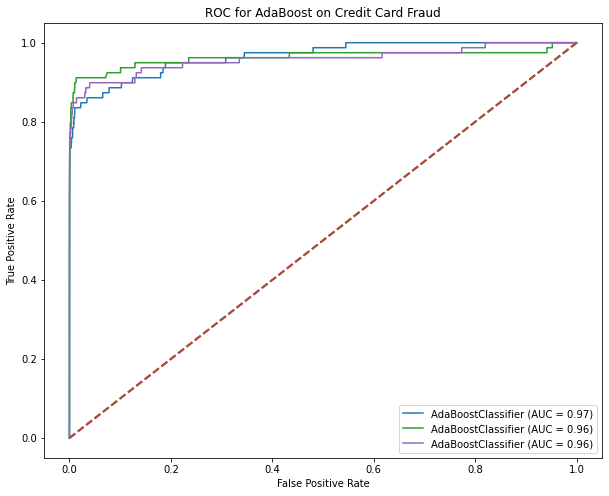

In [ ]:
ab_clf = AdaBoostClassifier(n_estimators=25, random_state=23)
fig, ax = plt.subplots(figsize=(10,8))

for fold in range(1, k+1):
    df_XCopy = df_X.copy()
    tpr = 0
    tnr = 0
    fpr = 0
    fnr = 0
    
    ab_clf.fit(d_train_df_X[fold], d_train_s_y[fold])    
    
    acc_ab[fold-1] = ab_clf.score(d_test_df_X[fold], d_test_s_y[fold])
    yTrue = list(d_test_s_y[fold])
    yHat = list(ab_clf.predict(d_test_df_X[fold]))

    for i in range(len(yHat)):
        if yTrue[i] == 1:
            if yHat[i] == 1:
                tpr += 1
            else:
                fnr += 1
                
        elif yTrue[i] == 0:
            if yHat[i] == 1:
                fpr += 1
            else:
                tnr += 1
        continue
    
    tpr_ab[fold-1] = (tpr)/(tpr + fnr)
    ppv_ab[fold-1] = (tpr)/(tpr + fpr)
    fpr_ab[fold-1] = (fpr)/(fpr + tnr)
    
    plot_roc_curve(ab_clf, d_test_df_X[fold], d_test_s_y[fold], ax=ax)
    ax.plot([0, 1], [0, 1], lw=2, linestyle='--', alpha=.8)
      
y_hat_ab = ab_clf.predict(d_test_df_X[3])
ax.set_title("ROC for AdaBoost on Credit Card Fraud")

In [ ]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))

The min, mean, and max TPR are: 0.62, 0.65, and 0.71
The min, mean, and max PPV are: 0.75, 0.79, and 0.82
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


## Q3 Test the Performance of Random Forests

Now, let's try another ensemble method: Random Forests, again using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

Following our book, we will build complete trees, with no pruning.  That means every leaf in the tree will be completelely pure, and if you exam an individual Decision Tree it would be overtrained to our training set.  While building the decision trees, at every internal node, we select $p$ attributes at random, and then find the best split that minimizes impurtity.  The value, $p$, is a hyperparamter of the Random Forest and corresponds to the `max_features` parameter in the Random Forest Class. 

After you fit an RandomForest model, you can call the method `predict` to get a class prediction, or you can call `predict_proba` to get the probability of being in the class `0` or the class `1`. These probabilities are used when creating ROC curves. 

Loop over the $k$ folds using the dictionaries from the first problem, and for each fold calculate the accuracy, TPR, the PPV, and the FPR (feel free to reuse the functions that you already wrote to calculate these values - do not use a library function to compute these metrics).  Plot the ROC curve for each fold. You may use the [plot roc curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) from Scikit-learn. There is a great example in the documentation [on plotting ROC curves in cross validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) that is helpful.  

When creating your Random Forest classifier, please use the following parameters: 
`RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)`

Save the predictions from the 3rd fold into a variable called `y_hat_rf` for use in a future problem.

In [ ]:
k = 3
acc_rf = np.zeros(k)
tpr_rf = np.zeros(k)
ppv_rf = np.zeros(k)
fpr_rf = np.zeros(k)

Text(0.5, 1.0, 'ROC for Random Forest on Credit Card Fraud')

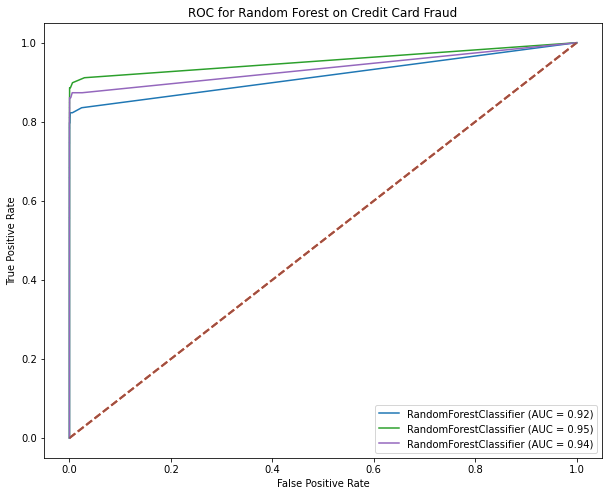

In [ ]:
for_clf = RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=23)
fig, ax = plt.subplots(figsize=(10,8))

for fold in range(1, k+1):
    tpr = 0
    tnr = 0
    fpr = 0
    fnr = 0

    for_clf.fit(d_train_df_X[fold], d_train_s_y[fold])

    acc_rf[fold-1] = for_clf.score(d_test_df_X[fold], d_test_s_y[fold])
    yTrue = list(d_test_s_y[fold])
    yHat = list(for_clf.predict(d_test_df_X[fold]))

    for i in range(len(yHat)):
        if yTrue[i] == 1:
            if yHat[i] == 1:
                tpr += 1
            else:
                fnr += 1
        elif yTrue[i] == 0:
            if yHat[i] == 1:
                fpr += 1
            else:
                tnr += 1
        continue
    
    tpr_rf[fold-1] = (tpr)/(tpr + fnr)
    ppv_rf[fold-1] = (tpr)/(tpr + fpr)
    fpr_rf[fold-1] = (fpr)/(fpr + tnr)
    
    plot_roc_curve(for_clf, d_test_df_X[fold], d_test_s_y[fold], ax=ax)
    ax.plot([0, 1], [0, 1], lw=2, linestyle='--', alpha=.8)
      
y_hat_rf = for_clf.predict(d_test_df_X[3])
ax.set_title("ROC for Random Forest on Credit Card Fraud")

In [ ]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

The min, mean, and max TPR are: 0.75, 0.78, and 0.80
The min, mean, and max PPV are: 0.92, 0.93, and 0.95
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


# Q4 Calculate the Cost of Fraud 

In the above problems, we saved the predictions of the 3rd fold into the variables `y_hat_ab` and `y_hat_rf` for the AdaBoost and RandomForest models respectively. 

Now, Mr. Bank Man wants you to tell him how much money he is going to save if he deploys either of these fraud algorithms to the real-time payment processing system.  Assume that there is not a currently deployed fraud detection algorithm.  

For every fraudulent transaction that is not predicted as fraudulent the bank looses twice the value of the transaction.  So, if a fradulent charge for €10 is undectected, it costs the bank €20.  Also, if a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction. 

Using the 3rd fold test sample, calculate how much money Mr Bank Man will save by deploying each algorithm, and make a recommendation of which algorithm to deploy to production.  To calculate savings to the bank, you must first calculate the cost of the status quo, which is having no algorithm deployed. 

In [ ]:
vals_df = pd.DataFrame(d_test_s_y[3])
fraud_positions = vals_df[vals_df['Class'] == 1].index.to_list()
status_quo = d_test_df_X[3].loc[fraud_positions]['Amount'].sum() * 2
print(f"The cost of not deploying an algorithm is €{status_quo}")

The cost of not deploying an algorithm is €22484.74


In [ ]:
abFalseNeg = []
abFalsePos = []

for i in range(len(d_test_s_y[3])):
    if (d_test_s_y[3].values[i] == 1) and (y_hat_ab[i] == 0):
        abFalseNeg.append(d_test_s_y[3].index[i])
    elif (d_test_s_y[3].values[i] == 0) and (y_hat_ab[i] == 1):
        abFalsePos.append(d_test_s_y[3].index[i])  
    continue
adaCost = (d_test_df_X[3].loc[abFalseNeg]['Amount'].sum() * 2) + (3 * len(abFalsePos))
print(f"The cost of deploying an AdaBoost algorithm is €{adaCost}")

The cost of deploying an AdaBoost algorithm is €8538.320000000002


In [ ]:
rfFalseNeg = []
rfFalsePos = []

for i in range(len(d_test_s_y[3])):
    if (d_test_s_y[3].values[i] == 1) and (y_hat_rf[i] == 0):
        rfFalseNeg.append(d_test_s_y[3].index[i])
    elif (d_test_s_y[3].values[i] == 0) and (y_hat_rf[i] == 1):
        rfFalsePos.append(d_test_s_y[3].index[i])  
    continue
rfCost = (d_test_df_X[3].loc[rfFalseNeg]['Amount'].sum() * 2) + (3 * len(rfFalsePos))
print(f"The cost of deploying a random forest algorithm is €{rfCost}")

The cost of deploying a random forest algorithm is €4363.380000000001


➡️ Mr Bank man will save €18121.36, if we deploy the random forest algorithm! ⬅️

In [ ]:
adaSavings = status_quo - adaCost
rfSavings = status_quo - rfCost
print(f"Ada savings: €{adaSavings}\n Random Forest Savings: €{rfSavings}")

Ada savings: €13946.42
 Random Forest Savings: €18121.36
